# Thesis Simulations
This notebook contains the code that creates all figures for the simulation and visualizations of the thesis.

In [1]:
from thesis import Dataset
from cblearn.datasets import make_all_triplets
from estimators import LandmarkTangles
from plotting import AltairPlotter, ThesisPlotter
from altair_saver import save
from sklearn.cluster import KMeans
from questionnaire import Questionnaire
from thesis import ClusteringEvaluationSuite, DataCache
from triplets import subsample_triplets, unify_triplet_order, triplets_to_majority_neighbour_cuts
from cblearn.embedding import SOE
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
import os
plt.style.use('bmh')
RESULTS_FOLDER = 'results'
INITIAL_SEED = 1
N_RUNS = 5
USED_EMBEDDERS = ["SOE", "CKL", "GNMDS", "FORTE", "TSTE"]
verbose=True
ap = AltairPlotter()
tp = ThesisPlotter(Path(RESULTS_FOLDER))
force_rerun = False
# %load_ext autoreload
# %autoreload 2
def print_(*args, **kwargs):
    if verbose:
        print(*args, **kwargs)

## Majority tangles

### Majority cuts appearance [Fig. TODO]
This figure shows how the majority cuts look like on a simple dataset.

#triplets = 100
#triplets = 500
#triplets = 1000
#triplets = 5000
#triplets = 10000
#triplets = 20000
#triplets = 50000
#triplets = 100000


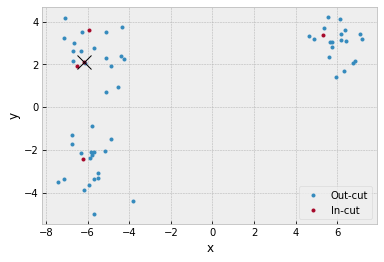

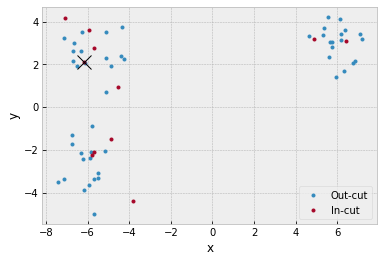

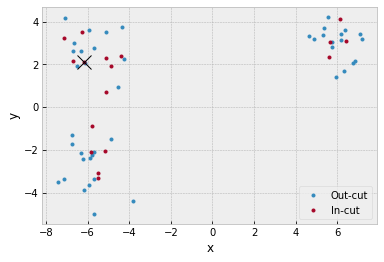

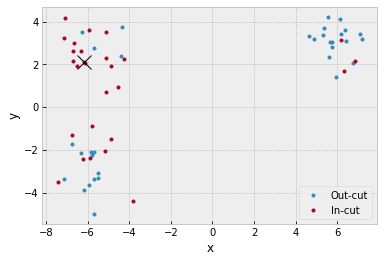

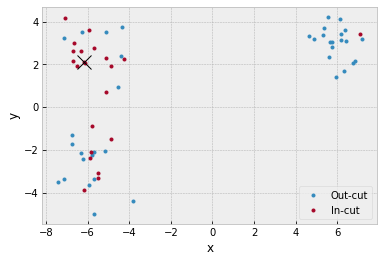

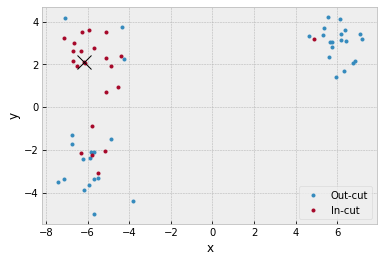

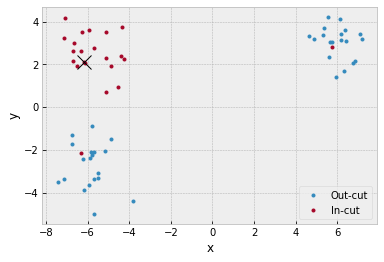

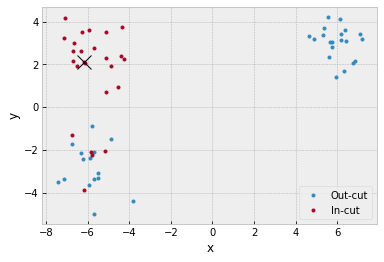

In [2]:
num_triplets = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]

data = Dataset.get(Dataset.GAUSS_SMALL, INITIAL_SEED)
for n in num_triplets:
    print_(f"#triplets = {n}")
    triplets, responses = subsample_triplets(data.xs, n)
    unified_triplets = unify_triplet_order(triplets, responses)
    cuts = triplets_to_majority_neighbour_cuts(
        unified_triplets, radius=1 / 2)

    p = 8
    tp.assignments(data.xs, cuts[p, :])
    plt.legend(["Out-cut", "In-cut"])
    plt.plot(data.xs[p, 0], data.xs[p, 1], "kx", markersize=14)
    tp.save(f"majority-cut-{p}-n_triplets-{n}")

### Adding noise (small) [Fig. TODO]
This figure shows how adding noise to majority cuts changes their performance.

In [3]:
def adding_noise_num_triplets(dataset, num_triplets, noises):
    seed = INITIAL_SEED
    for noise in noises:
        for num in num_triplets:
            print_(f"noise: {noise}, num_triplets: {num}")
            for n in range(N_RUNS):
                seed += 1
                data = Dataset.get(dataset, seed)
                t, r = subsample_triplets(data.xs, num, noise=noise)
                yield t, r, data.ys, {'num_triplets': num, 'run': n, 'noise': noise}

In [19]:
exp_name = "adding_noise_small_majority"
noises = np.arange(0, 0.51, 0.05)
#densities = [0.01]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["M-Tangles", "ComparisonHC"] + USED_EMBEDDERS, radius=1/2.3)
    df = eval_suite.score_all(adding_noise_num_triplets(Dataset.GAUSS_SMALL, num_triplets=[20000], noises=noises))
    cache.save(df)

noise: 0.0, num_triplets: 20000
noise: 0.05, num_triplets: 20000
noise: 0.1, num_triplets: 20000
noise: 0.15000000000000002, num_triplets: 20000
noise: 0.2, num_triplets: 20000
noise: 0.25, num_triplets: 20000
noise: 0.30000000000000004, num_triplets: 20000
noise: 0.35000000000000003, num_triplets: 20000
noise: 0.4, num_triplets: 20000
noise: 0.45, num_triplets: 20000
noise: 0.5, num_triplets: 20000


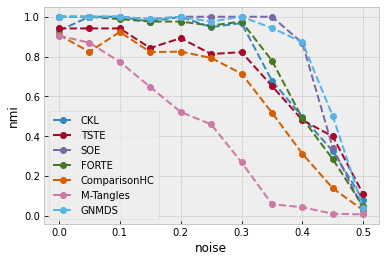

In [22]:
tp.line(cache.data, x="noise", y="nmi")

### Reducing number of triplets [Fig. TODO]
This figure shows how majority cuts behave with increasing/decreasing number of triplets.

In [6]:
exp_name = "reducing_triplets_small"
num_triplets = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, radius=1/2.3, methods_to_include=["M-Tangles", "ComparisonHC"] + USED_EMBEDDERS)
    df = eval_suite.score_all(adding_noise_num_triplets(Dataset.GAUSS_SMALL, num_triplets=num_triplets, noises=[0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/reducing_triplets_small.csv...


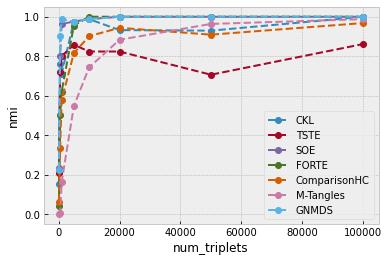

In [7]:
tp.line(cache.data, x="num_triplets", y="nmi")

## Landmark tangles

### All points gaussian (small) [Fig. TODO]
This figure shows the look of the general clustering and the dataset.

Text(0.5, 1.0, 'Used gaussian dataset')

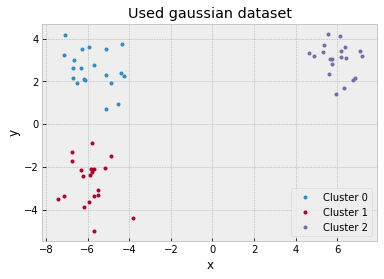

In [8]:
data = Dataset.get(Dataset.GAUSS_SMALL, INITIAL_SEED)
t,r = make_all_triplets(data.xs, "list-boolean")
tangles = LandmarkTangles(agreement=5, verbose=False)
ys = tangles.fit_predict(t, r)
tp.assignments(data.xs, ys)
plt.legend()
plt.title("Used gaussian dataset")

### Lowering density (small)
The figure shows how the landmark-tangles perform with decreasing number of landmark-questions.

In [9]:
def lowering_density_adding_noise_gen(dataset, densities, noises):
    seed = INITIAL_SEED
    for density in densities:
        for noise in noises:
            print(f"density: {density}, noise: {noise}")
            for n in range(N_RUNS):
                seed += 1
                data = Dataset.get(dataset, seed)
                t, r = Questionnaire.from_metric(data.xs, density=density, noise=noise, seed=seed, verbose=False, flip_noise=True).to_bool_array()
                yield t, r, data.ys, {'density': density, 'run': n, 'noise': noise}

In [10]:
exp_name = "lower_density_small"
densities = np.logspace(0, -4, 20)
#densities = [0.01]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities, noises=[0.0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_small.csv...


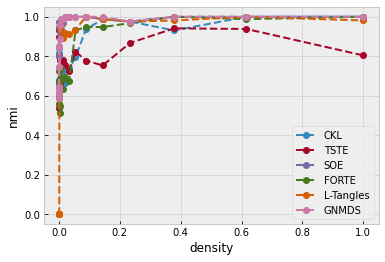

In [11]:
tp.line(cache.data, "density", "nmi")

### Lowering density (large) [Fig. TODO]
Similar to small, just bigger.

In [12]:
exp_name = "lower_density_large"
densities = np.logspace(-3, -5, 10).tolist()
#densities = [0.0001, 0.00008, 0.00005]
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load():
    eval_suite = ClusteringEvaluationSuite(70, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_LARGE, densities, noises=[0.0]))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_large.csv...


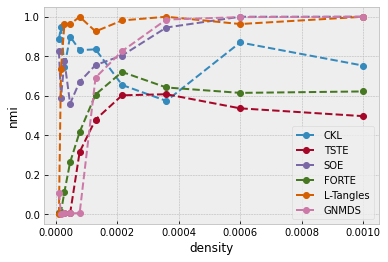

In [13]:
tp.line(cache.data, "density", "nmi")

### Adding noise and lowering density [Fig. TODO]
Shows how landmark tangles behaves in comparison to SOE (with randomly drawn triplets
and same triplets) when lowering both the density and adding noise.

In [14]:
exp_name = "lower_density_add_noise_small"
noises = np.arange(0, 0.41, 0.02)
densities = np.logspace(0, -4, 20)
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities, noises))
    cache.save(df)

Previous experiment result found.
Loading data from cache at results/lower_density_add_noise_small.csv...


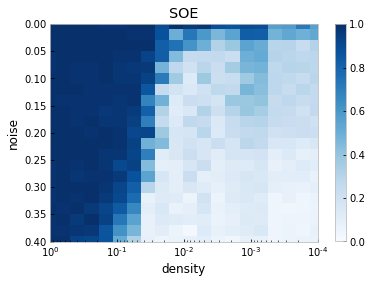

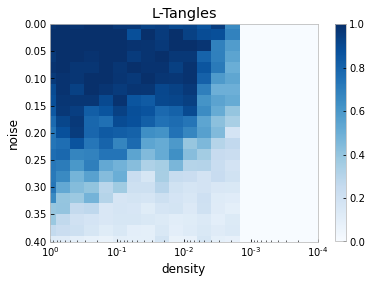

In [18]:
tp.heatmap(cache.data, "density", "noise", "nmi", "SOE")
plt.title("SOE")
tp.heatmap(cache.data, "density", "noise", "nmi", "L-Tangles")
plt.title("L-Tangles");

### Adding noise (small) [Fig. TODO]
Shows how landmark tangles behaves when adding noise to the triplets

In [ ]:
exp_name = "adding_noise_small"
noises = np.arange(0, 0.51, 0.01)
cache = DataCache(RESULTS_FOLDER, exp_name)
if force_rerun or not cache.load() :
    eval_suite = ClusteringEvaluationSuite(7, 2, KMeans(3), seed=0, methods_to_include=["L-Tangles"] + USED_EMBEDDERS)
    df = eval_suite.score_all(lowering_density_adding_noise_gen(Dataset.GAUSS_SMALL, densities=[1.0], noises=noises))
    cache.save(df)

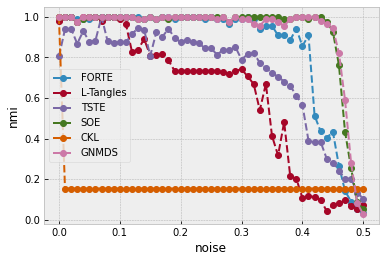

In [ ]:
tp.line(cache.data, "noise", "nmi")